In [1]:
### Install dependencies and import them
from time import time
!pip3 -q install ipytree~=0.2.1
!pip3 -q install matplotlib~=3.3.4

!pip3 -q install numpy~=1.19.2
!pip3 -q install python-dotenv~=0.15.0
!pip3 -q install s3fs~=0.5.2
!pip3 -q install zarr~=2.6.1
#!pip3 install s3fs
!pip3 -q install fsspec
!pip3 -q install seaborn
!pip3 -q install welly
!pip3 -q install real-simple-seismic
!pip3 -q install segyio
!pip3 -q install pylops
!pip3 -q install scikit-learn

from sklearn.linear_model import LinearRegression
import scipy as sp
from scipy import signal
import segyio
import pylops
from sklearn.linear_model import LinearRegression, RANSACRegressor
import numpy as np
from rss.client import rssFromS3
#import openvds
"""
from vds_utils import (
    get_minicube,
    get_slice,
    print_channel_info,
    print_crs_metadata,
)
"""
import matplotlib.pyplot as plt
from os import getenv
#!pip install pandas==1.2.0
#!pip3 install --upgrade pandas
import pandas as pd
print(pd.__version__)

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
You sh

# Setting up AWS Credentials
S3 buckets requires an access key and an access secret, and since nobody wants to
include a key and a secret in a notebook, we used `python-dotenv` to keep this
in a `.env` file together with the scripts. If the `.env` file is configured correctly
the next cell will load that into the current notebook kernel and create the necessary
parameter dictionary for pandas.

In [2]:
region_name = 'us-east-1'
aws_key = getenv(aws_key)
aws_secret = getenv(aws_secret)

s3_path_wb = 's3://geophysics-on-cloud/poseidon/horizons/water_bottom.csv.gz'
s3_path_top_hw = 's3://geophysics-on-cloud/poseidon/horizons/top_heywood.csv.gz'
s3_path_top_jam = 's3://geophysics-on-cloud/poseidon/horizons/top_jameison.csv.gz'
s3_path_top_joh = 's3://geophysics-on-cloud/poseidon/horizons/top_johnson.csv.gz'
s3_path_top_nearpl = 's3://geophysics-on-cloud/poseidon/horizons/top_near_plover.csv.gz'

s3_options = {
    'client_kwargs': {
        'aws_access_key_id': aws_key,
        'aws_secret_access_key': aws_secret,
        'region_name': region_name,
        }
    }
s3_options = None

# Reading Cloud Horizons into Pandas DataFrame
With the location and configuration above, now we can use the built in `pandas.read_json()`
function to download and deserialize the `JSON` file into a `pandas.DataFrame()`.
The file gets downloaded in a few seconds. Parsing the `JSON` takes longer.

In [3]:
def get_horizon(s3_path, s3_options):
    horizon_data = pd.read_csv(filepath_or_buffer=s3_path, compression='gzip', storage_options=s3_options,)
    
    horizon_data.set_index(['inline', 'xline'], inplace=True)

    print(f"Completed read in {time() - start_time} seconds")
    
    return horizon_data

start_time = time()
horizon_data_wb = get_horizon(s3_path_wb, s3_options)

start_time = time()
horizon_data_top_hw = get_horizon(s3_path_top_hw, s3_options)

start_time = time()
horizon_data_top_jam = get_horizon(s3_path_top_jam, s3_options)

start_time = time()
horizon_data_top_nearpl = get_horizon(s3_path_top_nearpl, s3_options)

start_time = time()
horizon_data_top_joh = get_horizon(s3_path_top_joh, s3_options)




Completed read in 18.603348970413208 seconds
Completed read in 21.540709018707275 seconds
Completed read in 24.2802951335907 seconds
Completed read in 31.471585750579834 seconds
Completed read in 26.335193157196045 seconds


# Data Description
### Raw Data

In [4]:
horizon_data_top_jam.head()

top_jameison
inline xline              
1080   1080         2719.2
       1081         2719.3
       1082         2719.5
       1083         2719.7
       1084         2720.0

In [5]:
horizon_data = pd.concat([horizon_data_wb, horizon_data_top_hw, horizon_data_top_jam, horizon_data_top_joh, horizon_data_top_nearpl], axis=1, join="inner")
horizon_data.head()

water_bottom  top_heywood  top_jameison  top_johnson  \
inline xline                                                         
1080   1080          581.9       2058.3        2719.2       2346.8   
       1081          581.8       2058.3        2719.3       2346.8   
       1082          581.8       2058.4        2719.5       2347.1   
       1083          581.8       2058.4        2719.7       2347.3   
       1084          581.8       2058.4        2720.0       2347.6   

              top_near_plover  
inline xline                   
1080   1080            3327.9  
       1081            3327.8  
       1082            3327.8  
       1083            3327.8  
       1084            3327.7

### Statistics

In [6]:
horizon_data.describe()

water_bottom   top_heywood  top_jameison   top_johnson  top_near_plover
count  5.559141e+06  5.559141e+06  5.559141e+06  5.559141e+06     5.559141e+06
mean   6.383200e+02  2.037907e+03  2.729175e+03  2.461852e+03     3.360496e+03
std    3.129056e+01  4.665124e+01  8.732290e+01  1.167919e+02     2.722061e+02
min    5.792000e+02  1.933000e+03  2.545700e+03  2.241500e+03     2.842800e+03
25%    6.121000e+02  2.007300e+03  2.677600e+03  2.367200e+03     3.224600e+03
50%    6.349000e+02  2.035000e+03  2.713800e+03  2.440000e+03     3.282800e+03
75%    6.604000e+02  2.067700e+03  2.766400e+03  2.549300e+03     3.372400e+03
max    7.261000e+02  2.177200e+03  3.096800e+03  2.780500e+03     4.436900e+03

# Plotting Horizons

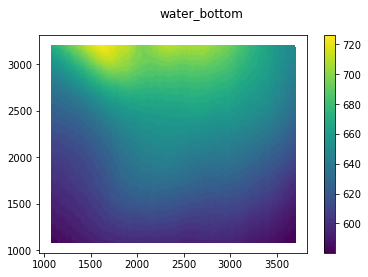

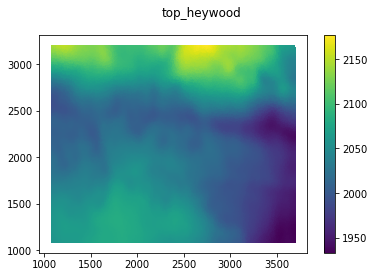

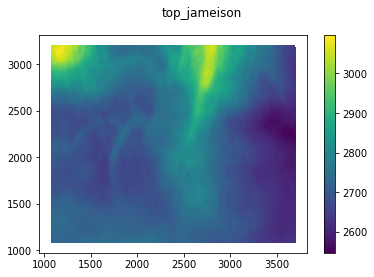

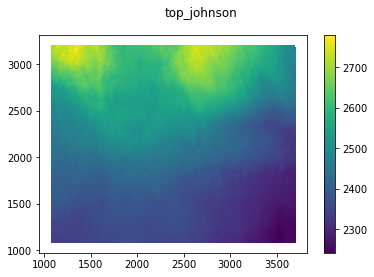

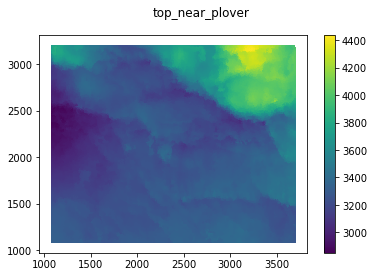

In [7]:
for horizon in horizon_data.columns:
    plt.figure()
    plt.suptitle(horizon)
    hrz = horizon_data[horizon]
    plt.tripcolor(
        hrz.index.get_level_values(0)[::50],
        hrz.index.get_level_values(1)[::50],
        hrz.values[::50],
    )
    plt.colorbar()

# Load and QC wells

In [8]:
s3_path = 's3://geophysics-on-cloud/poseidon/wells/poseidon_geoml_training_wells.json.gz'

With the location and configuration above, now we can use the built in `pandas.read_json()`
function to download and deserialize the `JSON` file into a `pandas.DataFrame()`.
The file gets downloaded in a few seconds. Parsing the `JSON` takes longer.

In [9]:
start_time = time()
well_data = pd.read_json(
    path_or_buf=s3_path,
    compression='gzip',
    storage_options=s3_options,
)

well_data.set_index(['well_id', 'twt'], inplace=True)

print(f"Completed read in {time() - start_time} seconds")

Completed read in 1.720749855041504 seconds


# Data Description
### Raw Data

In [10]:
well_data.head()

tvdss     inline      xline  rhob      dtc  dts
well_id twt                                                        
well_01 1136.5  2798.4675  2992.8834  2202.6259   NaN  58.3867  NaN
        1137.0  2798.4723  2992.8834  2202.6259   NaN  58.4215  NaN
        1137.5  2798.4771  2992.8834  2202.6258   NaN  58.4564  NaN
        1138.0  2798.4819  2992.8834  2202.6258   NaN  58.4912  NaN
        1138.5  2798.4867  2992.8834  2202.6258   NaN  58.5260  NaN

In [11]:
well_data.describe()

tvdss        inline         xline         rhob           dtc  \
count  14824.000000  14824.000000  14824.000000  5890.000000  14128.000000   
mean    3835.716897   2763.672636   2174.838334     2.554034     77.769123   
std      763.584958    664.046012    327.211822     0.118374     12.888939   
min     2478.476200   1193.294400   1490.623300     1.440400     44.142900   
25%     3058.992275   2766.629700   2202.617800     2.501700     67.630775   
50%     3941.296500   2992.712050   2285.735600     2.551600     75.625350   
75%     4456.250325   2993.014750   2397.199250     2.616375     87.356375   
max     5312.898000   3523.953900   2517.695300     3.446700    161.647900   

               dts  
count  4605.000000  
mean    151.618095  
std      41.149264  
min      74.608600  
25%     116.093500  
50%     147.974300  
75%     177.911600  
max     269.232400

# Plotting Wells

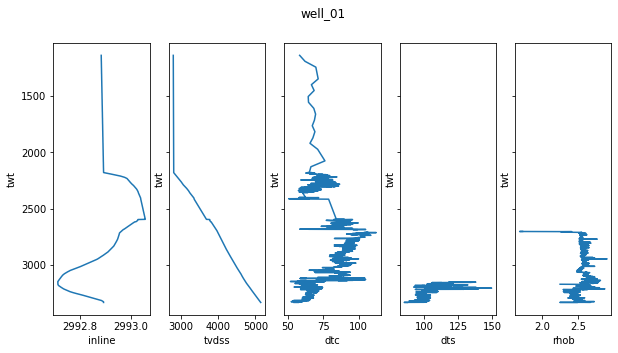

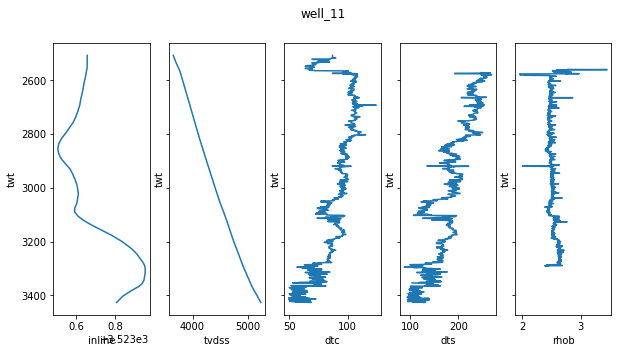

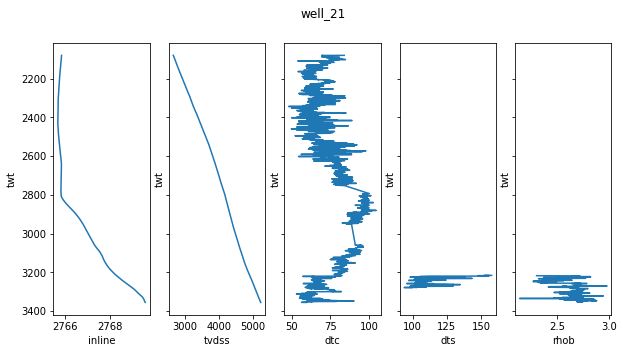

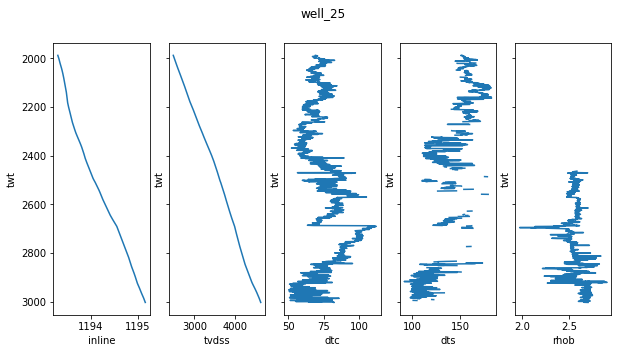

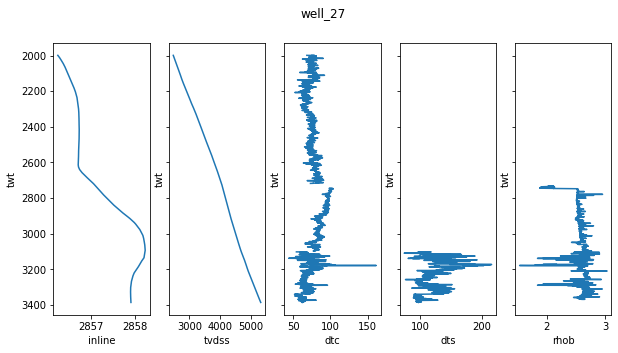

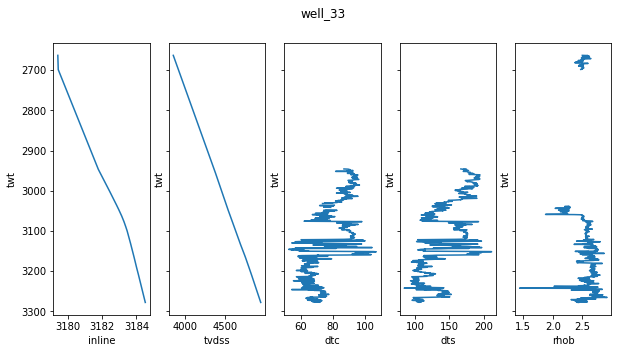

In [12]:
for well in well_data.index.levels[0]:
    fig, ax = plt.subplots(1, 5, sharey='all',figsize=(10,5))
    curves = well_data.loc[well][['inline','tvdss','dtc', 'dts', 'rhob']]
    fig.suptitle(well)
    for idx, curve in enumerate(curves.columns):
        ax[idx].plot(curves[curve], curves[curve].index)
        ax[idx].set_ylabel(curves[curve].index.name)
        ax[idx].set_xlabel(curves[curve].name)

    ax[0].invert_yaxis()

In [13]:
# Find the number of wells
no_of_well = well_data.index.get_level_values('well_id').unique()
print(no_of_well)
print(len(no_of_well))

Index(['well_01', 'well_11', 'well_21', 'well_25', 'well_27', 'well_33'], dtype='object', name='well_id')
6


We have 6 wells - where are they located?

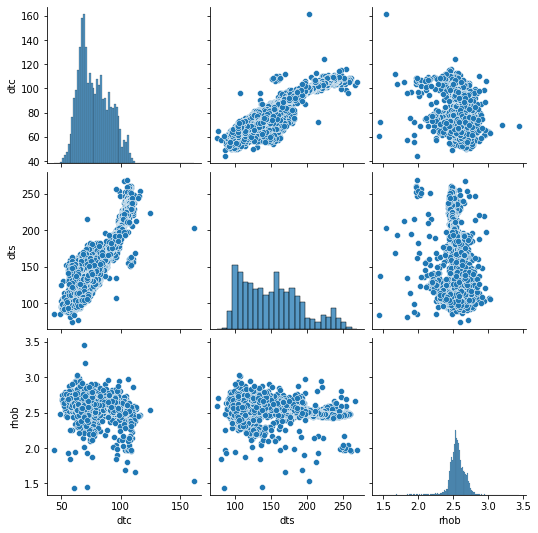

In [14]:
import seaborn as sns
from scipy import stats

sns.pairplot(well_data[['dtc', 'dts', 'rhob']]) #,height=3, aspect=.8, kind="reg")

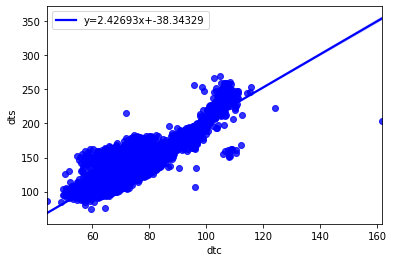

In [15]:
# get coeffs of linear fit - dts vs dtc

tmp_well = well_data[['dtc', 'dts']].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(tmp_well['dtc'],tmp_well['dts'])

# use line_kws to set line label for legend
ax = sns.regplot(x="dtc", y="dts", data=tmp_well, color='b', 
 line_kws={'label':"y={0:.5f}x+{1:.5f}".format(slope,intercept)})

# plot legend
ax.legend()

plt.show()

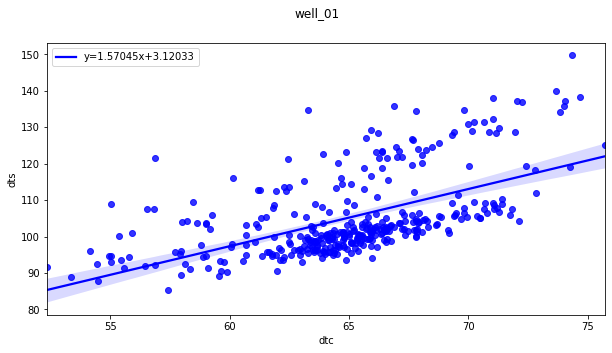

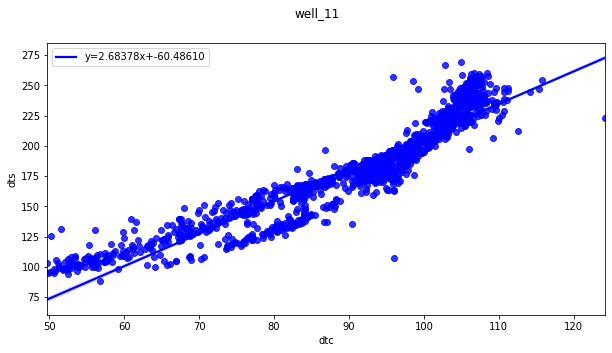

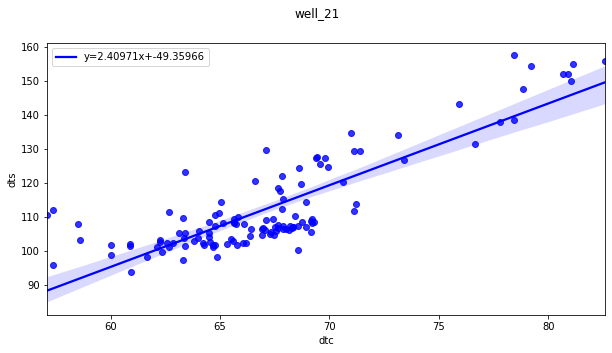

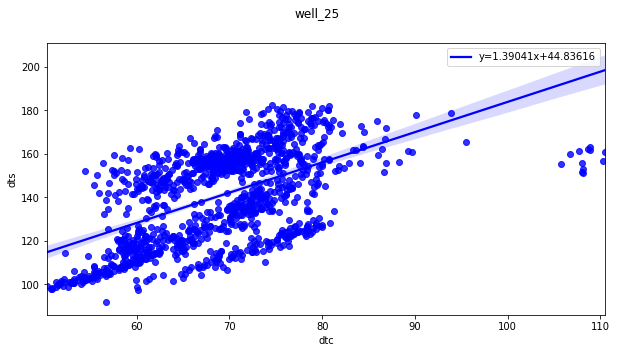

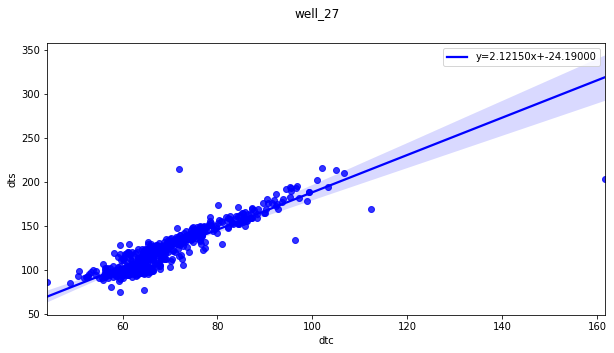

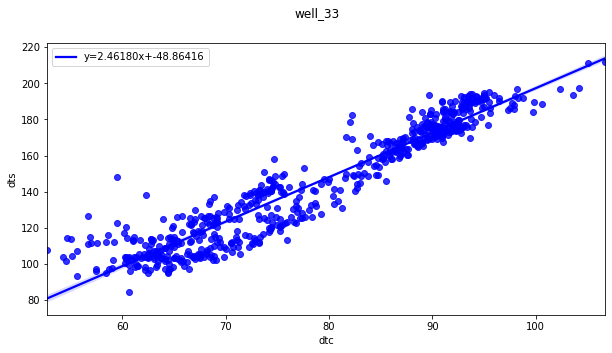

In [16]:
## Linear regression fit using sns
well_data['dts_calw'] = 0*well_data['dtc']
for well in well_data.index.levels[0]:
    fig, ax = plt.subplots(1, 1, sharey='all',figsize=(10,5))
    tmp_well = well_data.loc[well][['dtc', 'dts']]
    curves = tmp_well[['dtc', 'dts']].dropna()
    slope, intercept, r_value, p_value, std_err = stats.linregress(curves['dtc'],curves['dts'])
    
    well_data.loc[well]['dts_calw'] = slope*well_data.loc[well]['dtc'] + intercept
    
    fig.suptitle(well)
    ax = sns.regplot(x="dtc", y="dts", data=curves, color='b', 
      line_kws={'label':"y={0:.5f}x+{1:.5f}".format(slope,intercept)})
    # plot legend
    ax.legend()

    plt.show()

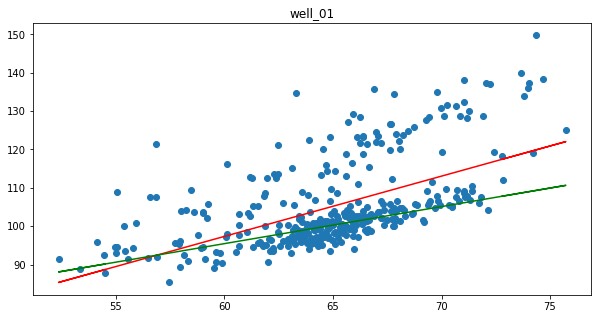

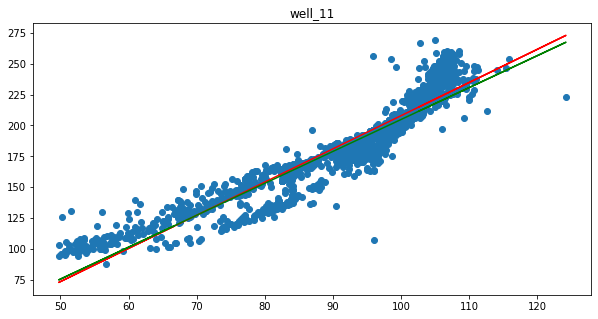

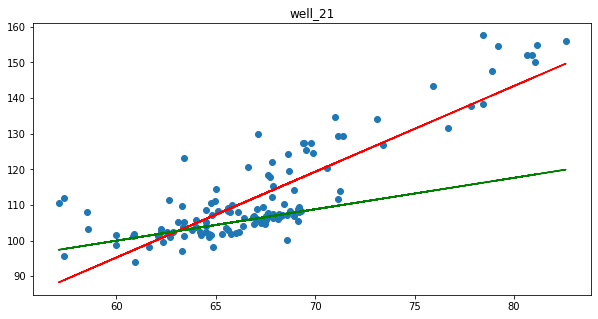

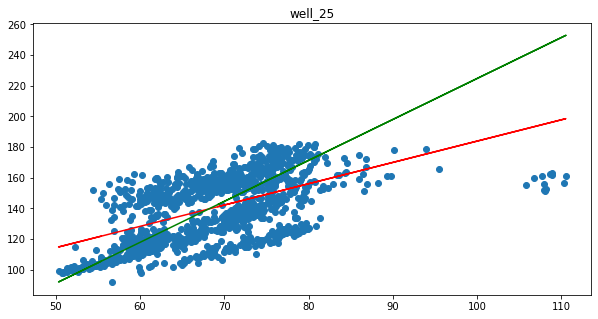

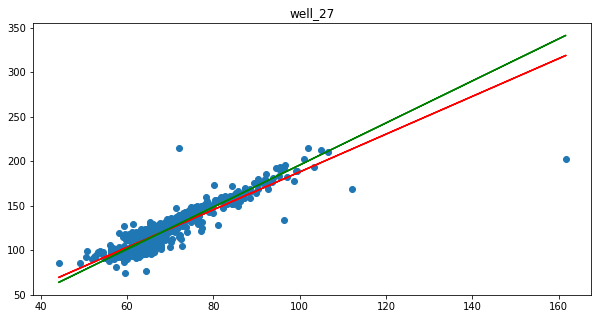

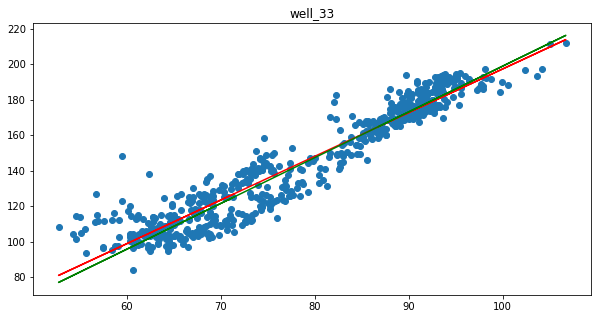

In [17]:
## Linear regression fit using sklearn and a robust linear fit with RANSAC
### Linear regression and its robust one dtc vs dts - individual wells
ransac = RANSACRegressor()
lmodel = LinearRegression(fit_intercept=True)

well_data['dts_calw'] = 0*well_data['dtc']
well_data['dts_calw_r'] = 0*well_data['dtc']
for well in well_data.index.levels[0]:
    fig, ax = plt.subplots(1, 1, sharey='all',figsize=(10,5))
    tmp_well = well_data.loc[well][['dtc', 'dts']]
    curves = tmp_well[['dtc', 'dts']].dropna()
    slope, intercept, r_value, p_value, std_err = stats.linregress(curves['dtc'],curves['dts'])
    
    
    dtc_arr = np.reshape(curves['dtc'].values, (len(curves['dtc'].values), 1))
    lmodel.fit(dtc_arr, curves['dts'].values)
    ransac.fit(dtc_arr, curves['dts'].values)
    well_data.loc[well]['dts_calw'] = slope*well_data.loc[well]['dtc'] + intercept
    well_data.loc[well]['dts_calw_r'] = ransac.estimator_.coef_*well_data.loc[well]['dtc'] + ransac.estimator_.intercept_
    
    #fig.suptitle(well)
    #ax = sns.regplot(x="dtc", y="rhob", data=curves, color='b', 
    #  line_kws={'label':"y={0:.5f}x+{1:.5f}".format(slope,intercept)})
    # plot legend
    #ax.legend()
    line_X = dtc_arr
    line_y = lmodel.predict(line_X)
    line_y_ransac = ransac.predict(line_X)

    #ax.figure(figsize=(2,10))
    ax.scatter(line_X, curves['dts'].values)
    ax.plot(line_X, line_y, 'r');
    ax.plot(line_X, line_y_ransac, 'g');
    plt.title(well)
    
    plt.show()

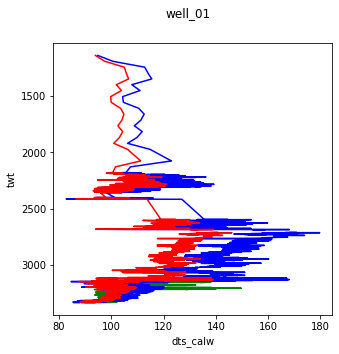

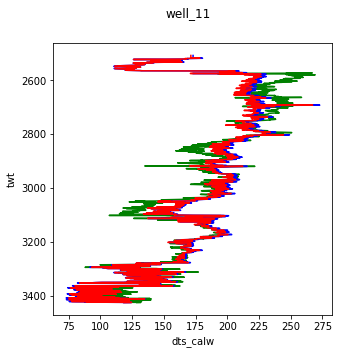

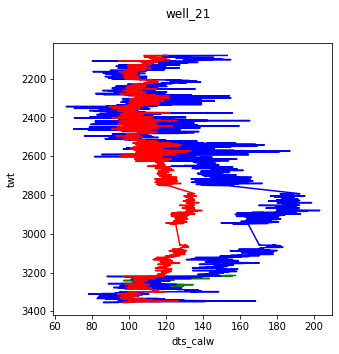

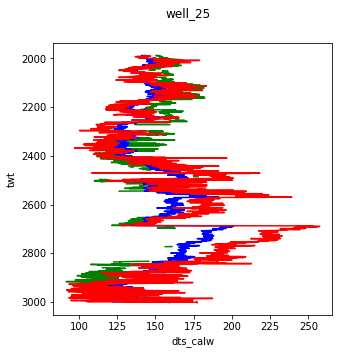

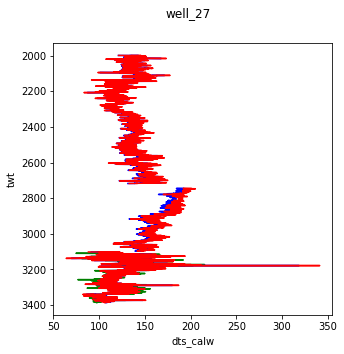

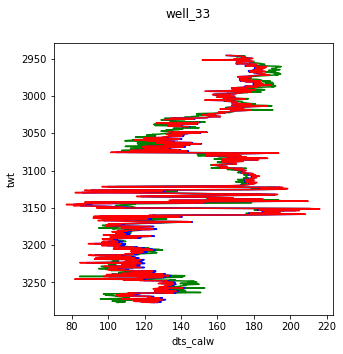

In [18]:
# Comparing the linear fits with the original log - DTS
for well in well_data.index.levels[0]:
    fig, ax = plt.subplots(1, 1, sharey='all',figsize=(5,5))
    curves = well_data.loc[well][['dts', 'dts_calw','dts_calw_r']]
    fig.suptitle(well)
    #for idx, curve in enumerate(curves.columns):
    ax.plot(curves['dts'], curves['dts'].index, 'g')
    ax.plot(curves['dts_calw'], curves['dts_calw'].index, 'b')
    ax.plot(curves['dts_calw_r'], curves['dts_calw_r'].index, 'r')
    ax.set_ylabel(curves['dts_calw'].index.name)
    ax.set_xlabel(curves['dts_calw'].name)
    #plt.ylim((3000,4000))
    ax.invert_yaxis()

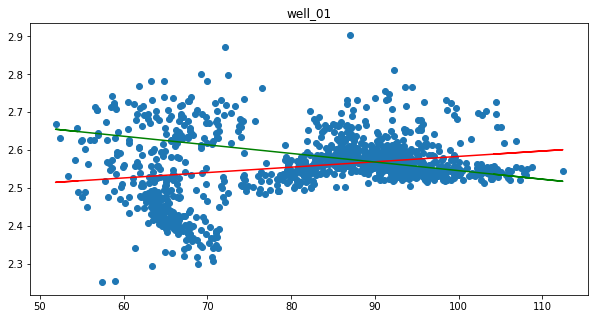

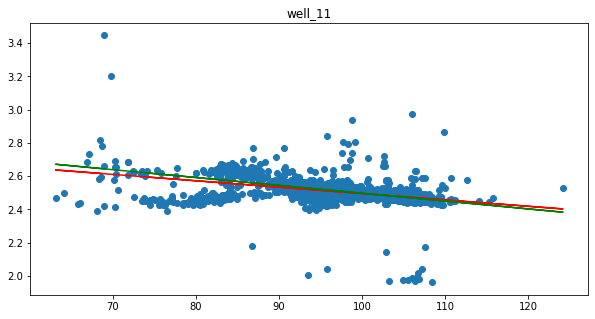

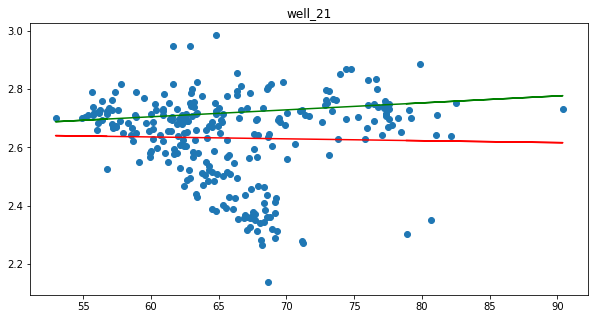

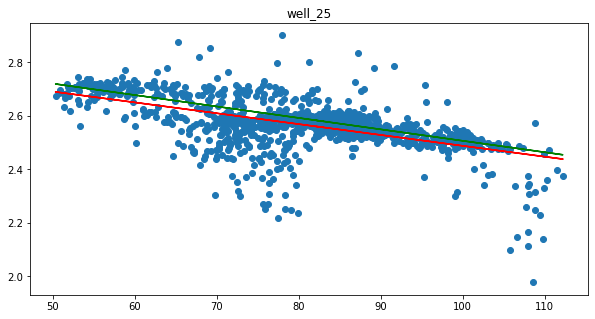

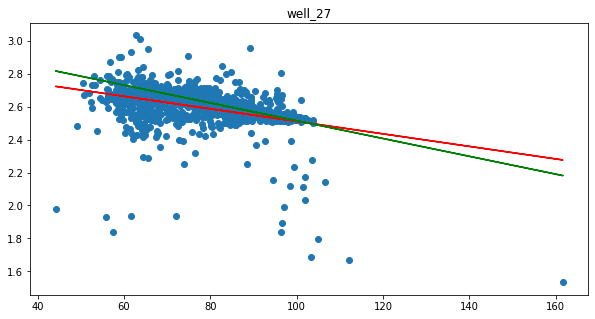

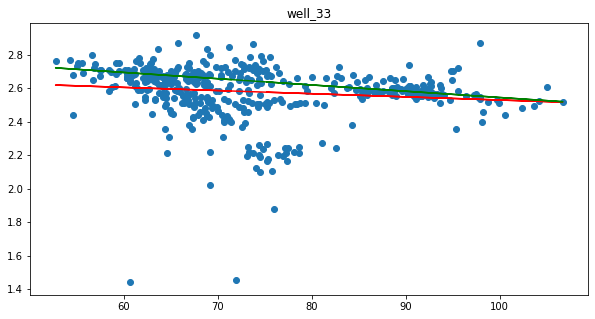

In [19]:
### Linear regression and its robust one dtc vs rhos - individual wells
ransac = RANSACRegressor()
lmodel = LinearRegression(fit_intercept=True)

well_data['rhob_calw'] = 0*well_data['dtc']
well_data['rhob_calw_r'] = 0*well_data['dtc']
for well in well_data.index.levels[0]:
    fig, ax = plt.subplots(1, 1, sharey='all',figsize=(10,5))
    tmp_well = well_data.loc[well][['dtc', 'rhob']]
    curves = tmp_well[['dtc', 'rhob']].dropna()
    slope, intercept, r_value, p_value, std_err = stats.linregress(curves['dtc'],curves['rhob'])
    
    
    dtc_arr = np.reshape(curves['dtc'].values, (len(curves['dtc'].values), 1))
    lmodel.fit(dtc_arr, curves['rhob'].values)
    ransac.fit(dtc_arr, curves['rhob'].values)
    well_data.loc[well]['rhob_calw'] = slope*well_data.loc[well]['dtc'] + intercept
    well_data.loc[well]['rhob_calw_r'] = ransac.estimator_.coef_*well_data.loc[well]['dtc'] + ransac.estimator_.intercept_
    
    #fig.suptitle(well)
    #ax = sns.regplot(x="dtc", y="rhob", data=curves, color='b', 
    #  line_kws={'label':"y={0:.5f}x+{1:.5f}".format(slope,intercept)})
    # plot legend
    #ax.legend()
    line_X = dtc_arr
    line_y = lmodel.predict(line_X)
    line_y_ransac = ransac.predict(line_X)

    #ax.figure(figsize=(2,10))
    ax.scatter(line_X, curves['rhob'].values)
    ax.plot(line_X, line_y, 'r');
    ax.plot(line_X, line_y_ransac, 'g');
    plt.title(well)
    
    plt.show()

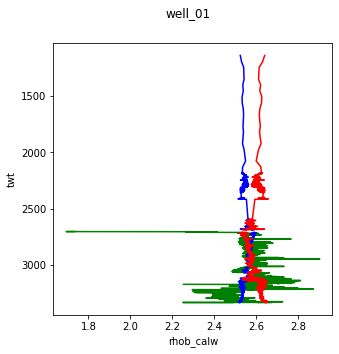

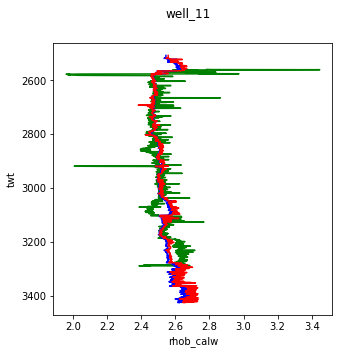

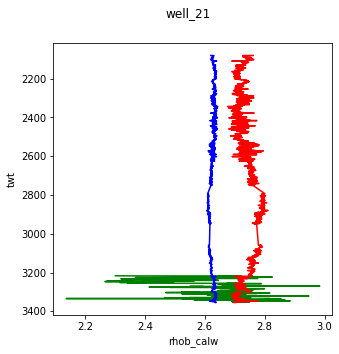

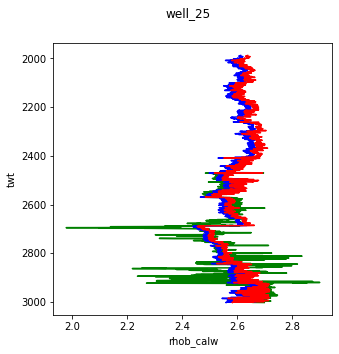

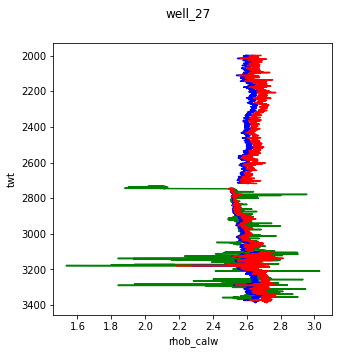

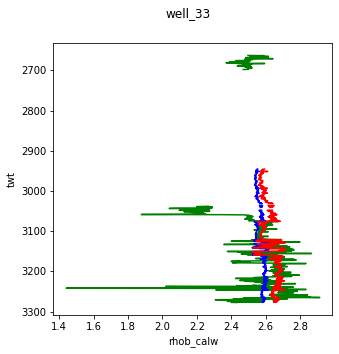

In [20]:
# Comparing the linear fits with the original log - rhob
#well_data['dts_cal'] = slope*well_data['dtc'] + intercept

for well in well_data.index.levels[0]:
    fig, ax = plt.subplots(1, 1, sharey='all',figsize=(5,5))
    curves = well_data.loc[well][['rhob', 'rhob_calw','rhob_calw_r']]
    fig.suptitle(well)
    #for idx, curve in enumerate(curves.columns):
    ax.plot(curves['rhob'], curves['rhob'].index, 'g')
    ax.plot(curves['rhob_calw'], curves['rhob_calw'].index, 'b')
    ax.plot(curves['rhob_calw_r'], curves['rhob_calw_r'].index, 'r')
    ax.set_ylabel(curves['rhob_calw'].index.name)
    ax.set_xlabel(curves['rhob_calw'].name)
    ax.invert_yaxis()

In [21]:
well_data.head()

tvdss     inline      xline  rhob      dtc  dts  \
well_id twt                                                           
well_01 1136.5  2798.4675  2992.8834  2202.6259   NaN  58.3867  NaN   
        1137.0  2798.4723  2992.8834  2202.6259   NaN  58.4215  NaN   
        1137.5  2798.4771  2992.8834  2202.6258   NaN  58.4564  NaN   
        1138.0  2798.4819  2992.8834  2202.6258   NaN  58.4912  NaN   
        1138.5  2798.4867  2992.8834  2202.6258   NaN  58.5260  NaN   

                 dts_calw  dts_calw_r  rhob_calw  rhob_calw_r  
well_id twt                                                    
well_01 1136.5  94.813819   93.902749   2.524116     2.640191  
        1137.0  94.868471   93.936350   2.524166     2.640112  
        1137.5  94.923280   93.970048   2.524215     2.640033  
        1138.0  94.977932   94.003648   2.524265     2.639954  
        1138.5  95.032583   94.037249   2.524314     2.639875

In [22]:
## rhob_new and dts_new - are the new to be rhob and dts logs to be used for training 
## after the nans
well_data['dts_new'] = well_data.dts
well_data['rhob_new'] = well_data.rhob

# Replace nans in dts from pseudo dts
well_data.dts_new.fillna(well_data.dts_calw, inplace=True)
well_data.rhob_new.fillna(well_data.rhob_calw_r, inplace=True)

## Impedance
well_data['imp_dtc_new'] = np.diff(1000000*well_data['rhob_new']/well_data['dtc'], prepend=np.nan)
well_data['imp_dts_new'] = np.diff(1000000*well_data['rhob_new']/well_data['dts_new'], prepend=np.nan)

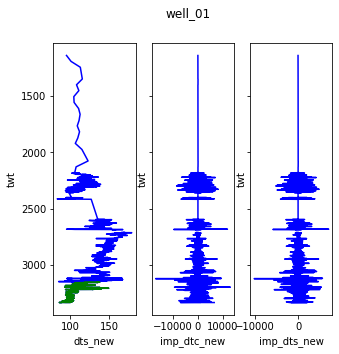

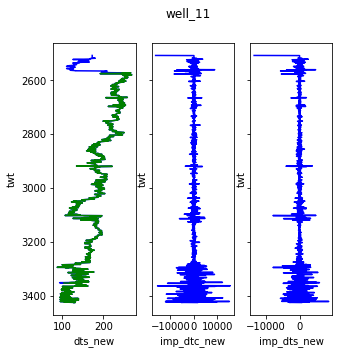

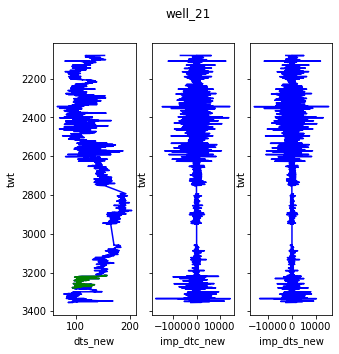

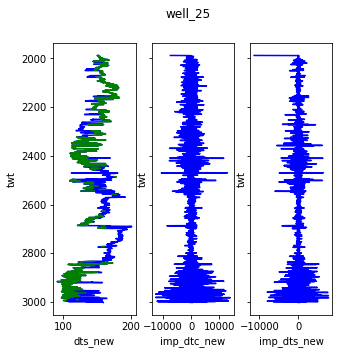

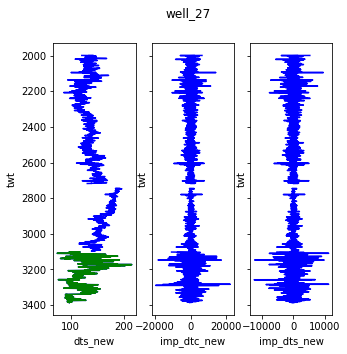

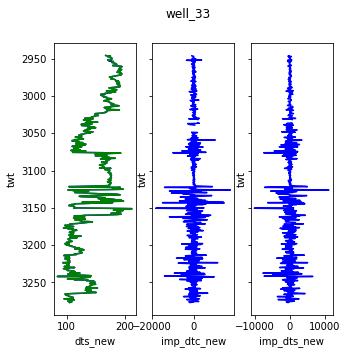

In [23]:
### QC logs after replacing NaNs
## For dts
for well in well_data.index.levels[0]:
    fig, ax = plt.subplots(1, 3, sharey='all',figsize=(5,5))
    curves = well_data.loc[well][['dts', 'dts_new', 'imp_dtc_new', 'imp_dts_new']]
    fig.suptitle(well)
    #for idx, curve in enumerate(curves.columns):
    ax[0].plot(curves['dts_new'], curves['dts_new'].index, 'b')
    ax[0].plot(curves['dts'], curves['dts'].index, 'g')
    #ax[0].plot(curves['dts_calw_r'], curves['dts_calw_r'].index, 'r')
    ax[0].set_ylabel(curves['dts_new'].index.name)
    ax[0].set_xlabel(curves['dts_new'].name)
    #plt.ylim((3000,4000))
    ax[1].plot(curves['imp_dtc_new'], curves['imp_dtc_new'].index, 'b')
    #ax[1].plot(curves['dts'], curves['dts'].index, 'g')
    #ax[1].plot(curves['dts_calw_r'], curves['dts_calw_r'].index, 'r')
    ax[1].set_ylabel(curves['imp_dtc_new'].index.name)
    ax[1].set_xlabel(curves['imp_dtc_new'].name)
    
    ax[2].plot(curves['imp_dts_new'], curves['imp_dts_new'].index, 'b')
    #ax[2].plot(curves['dts'], curves['dts'].index, 'g')
    #ax[2].plot(curves['dts_calw_r'], curves['dts_calw_r'].index, 'r')
    ax[2].set_ylabel(curves['imp_dts_new'].index.name)
    ax[2].set_xlabel(curves['imp_dts_new'].name)
    
    ax[0].invert_yaxis()

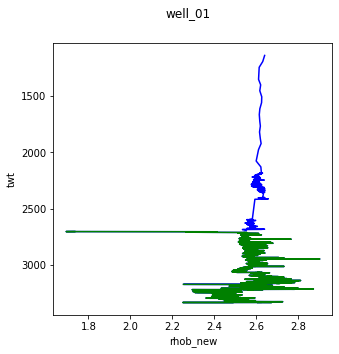

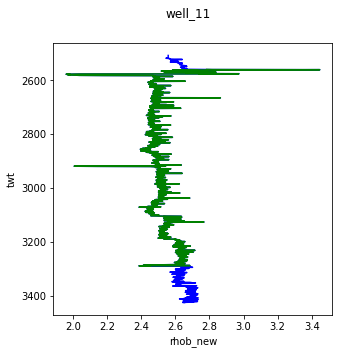

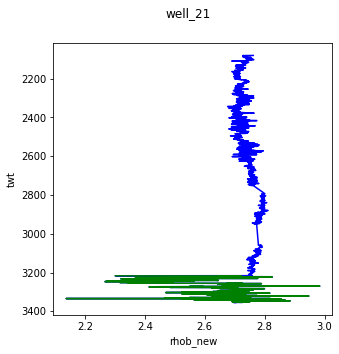

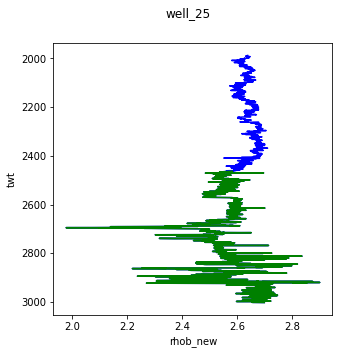

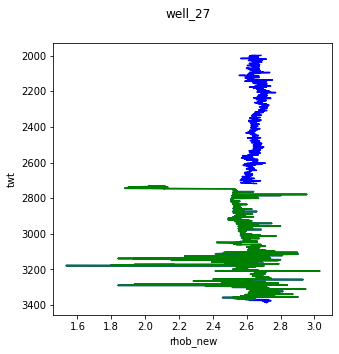

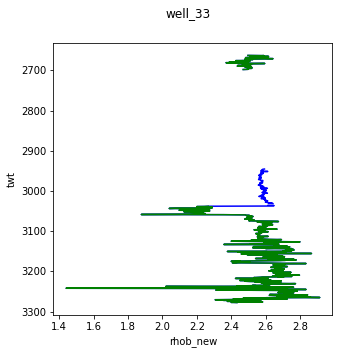

In [24]:
### QC logs after replacing NaNs
## For rhob
for well in well_data.index.levels[0]:
    fig, ax = plt.subplots(1, 1, sharey='all',figsize=(5,5))
    curves = well_data.loc[well][['rhob', 'rhob_new']]
    fig.suptitle(well)
    #for idx, curve in enumerate(curves.columns):
    ax.plot(curves['rhob_new'], curves['rhob_new'].index, 'b')
    ax.plot(curves['rhob'], curves['rhob'].index, 'g')
    #ax.plot(curves['dts_calw_r'], curves['dts_calw_r'].index, 'r')
    ax.set_ylabel(curves['rhob_new'].index.name)
    ax.set_xlabel(curves['rhob_new'].name)
    #plt.ylim((3000,4000))
    ax.invert_yaxis()

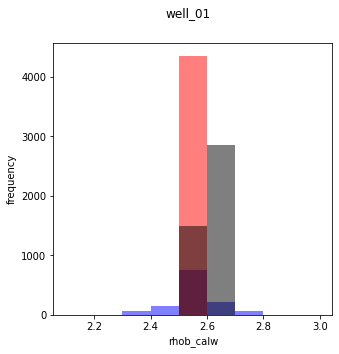

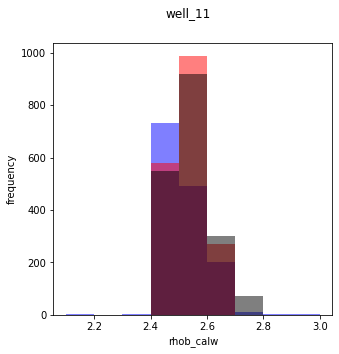

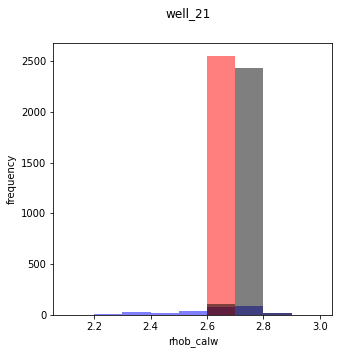

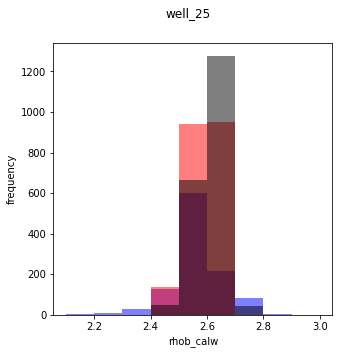

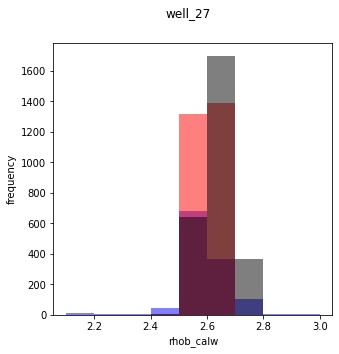

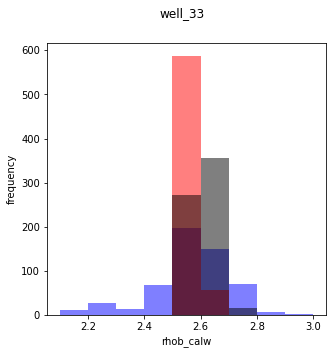

In [25]:
# Histogram
bin_edges = [2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]
for well in well_data.index.levels[0]:
    fig, ax = plt.subplots(1, 1, sharey='all',figsize=(5,5))
    curves = well_data.loc[well][['rhob', 'rhob_calw','rhob_calw_r']]
    fig.suptitle(well)
    #for idx, curve in enumerate(curves.columns):
    ax.hist(curves['rhob'], bins=bin_edges, ls='dashed', lw=3, fc=(0, 0, 1, 0.5)) #, curves['rhob'].index, 'g')
    ax.hist(curves['rhob_calw'], bins=bin_edges, ls='dotted', lw=3, fc=(1, 0, 0, 0.5)) #, curves['rhob_calw'].index, 'b')
    ax.hist(curves['rhob_calw_r'], bins=bin_edges, lw=3, fc=(0, 0, 0, 0.5)) #, curves['rhob_calw_r'].index, 'r')
    ax.set_ylabel('frequency')
    ax.set_xlabel(curves['rhob_calw'].name)
    #plt.ylim((3000,4000))
    #ax.invert_yaxis()

In [26]:
## Plot the dtc vs rhob - individual wells - maybe prep dtc well
## extract the horizon layer from the well data


In [27]:
tmp_well = well_data[['dtc', 'dts']].dropna()
tmp_well.describe()

dtc          dts
count  4584.000000  4584.000000
mean     78.299738   151.684948
std      15.501760    41.228882
min      44.142900    74.608600
25%      65.655050   115.915950
50%      74.400500   148.173300
75%      92.165775   178.000000
max     161.647900   269.232400

# QC Seismic

In [28]:
from rss.client import rssFromS3

In [29]:
%load_ext dotenv
%dotenv

client_kwargs = {'aws_access_key_id': ....,
                 'aws_secret_access_key': ....}

rss = rssFromS3('s3://geophysics-on-cloud/poseidon/seismic/rss/psdn11_TbsdmF_full_w_AGC_Nov11', client_kwargs)
rss_n = rssFromS3('s3://geophysics-on-cloud/poseidon/seismic/rss/psdn11_TbsdmF_Near_Nov_11_32bit', client_kwargs)
rss_m = rssFromS3('s3://geophysics-on-cloud/poseidon/seismic/rss/psdn11_TbsdmF_Mid_Nov_11_32bit', client_kwargs)
rss_f = rssFromS3('s3://geophysics-on-cloud/poseidon/seismic/rss/psdn11_TbsdmF_Far_Nov_11_32bit', client_kwargs)

Connection complete.


### Header information
The rss object contains the header information, x/y (easting and northing) and the 
il/xl coordinates. If you're interested, the CRS is GDA95, which is EPSG:28355. This 
data is for each trace in the file, in the order the trace occured in the original 
SEGY data.

In [30]:
#x/y header data, with coordinate scalar applied
rss.xy

array([[4.16132230e+09, 8.44759437e+10],
       [4.16122650e+09, 8.44760240e+10],
       [4.16113080e+09, 8.44761044e+10],
       ...,
       [4.09188360e+09, 8.53752404e+10],
       [4.09178790e+09, 8.53753208e+10],
       [4.09169210e+09, 8.53754011e+10]])

In [31]:
#inline/xline header data
rss.ilxl

array([[ 983,  504],
       [ 983,  505],
       [ 983,  506],
       ...,
       [4419, 5554],
       [4419, 5555],
       [4419, 5556]])

### Loading individual traces
You can load an individual trace by it's inline/xline coordinate. Understand that loading a 
single trace will also being down an entire line from storage, so it won't be faster than 
loading a line. However, neighbouring traces will be cached locally.

Elapsed Time (loading) :  4.553622007369995
Elapsed Time (caching) :  0.1389448642730713


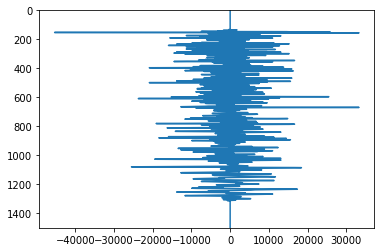

In [32]:
import numpy as np
st = time()
trace, is_live = rss.trace(1337, 2000)
print ("Elapsed Time (loading) : ", time() - st)

st = time()
trace, is_live = rss.trace(1337, 2000)
print ("Elapsed Time (caching) : ", time() - st)

plt.figure()
plt.plot(trace, np.arange(len(trace)))
plt.ylim([len(trace),0])
plt.show()

### Getting slices:
The data is optimized for reads in the inline and crossline directions, 
and reads are cached.

Elapsed Time (loading) :  5.306410074234009
Elapsed Time (loading):  4.959084987640381
Elapsed Time (caching):  0.19376015663146973


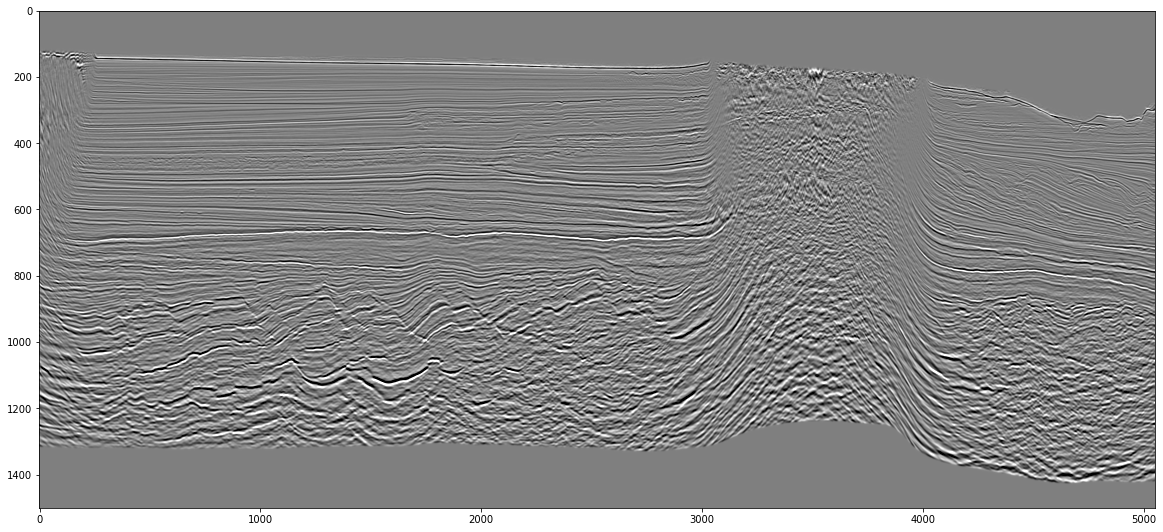

In [33]:
st = time()
inline, mask = rss.line(2002, sort_order='inline')
print ("Elapsed Time (loading) : ", time() - st)

st = time()
inline, mask = rss.line(2003, sort_order='inline')
print ("Elapsed Time (loading): ", time() - st)

st = time()
inline, mask = rss.line(2002, sort_order='inline')
print ("Elapsed Time (caching): ", time() - st)

plt.figure(figsize=(20,20))
plt.imshow(inline, cmap='gray', 
           interpolation='bicubic',
           aspect=1.5,
           vmin=-2*np.std(inline[~mask]), vmax=2*np.std(inline[~mask]))
plt.show()

Elapsed Time (loading):  2.861362934112549
Elapsed Time (loading):  2.711632251739502
Elapsed Time (caching):  0.17578887939453125


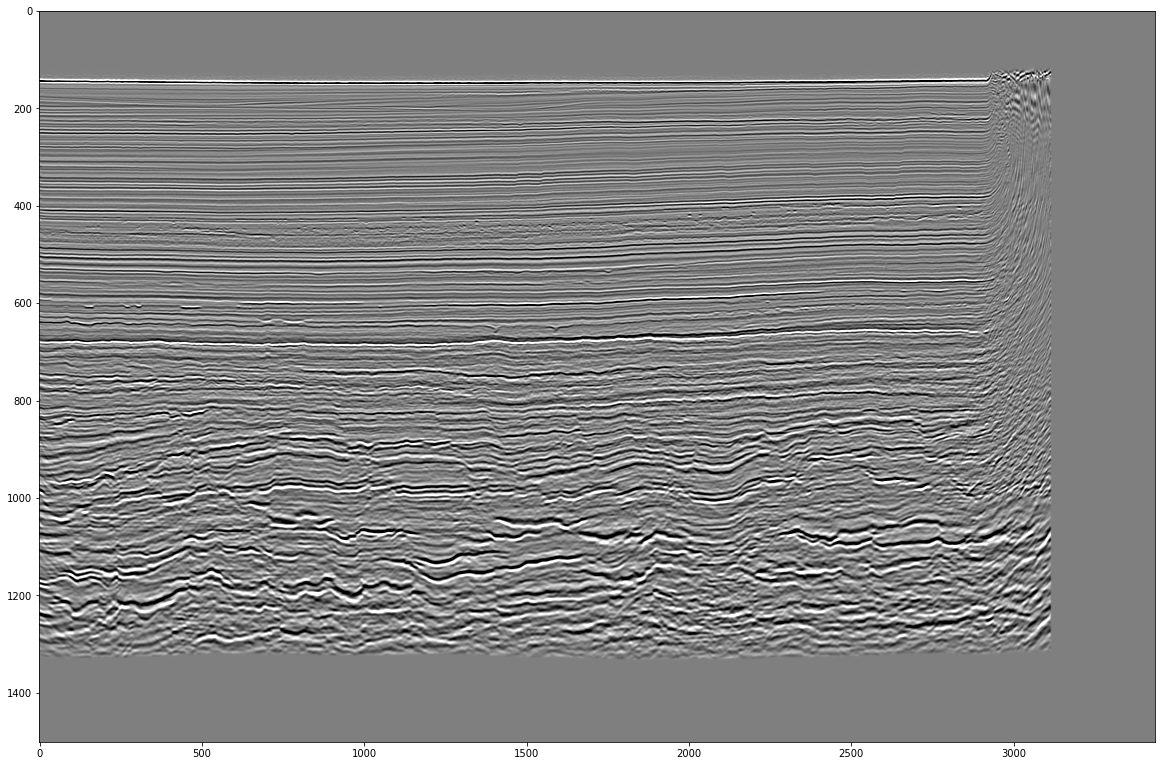

In [34]:
from time import time
st = time()
inline, mask = rss.line(1100, sort_order='crossline')
print ("Elapsed Time (loading): ", time() - st)

st = time()
inline, mask = rss.line(1101, sort_order='crossline')
print ("Elapsed Time (loading): ", time() - st)

st = time()
inline, mask = rss.line(1100, sort_order='crossline')
print ("Elapsed Time (caching): ", time() - st)

plt.figure(figsize=(20,20))
plt.imshow(inline, cmap='gray', 
           aspect=1.5, 
           interpolation='bicubic',
           vmin=-2*np.std(inline[~mask]), vmax=2*np.std(inline[~mask]))
plt.show()

### Map x/y -> inline/xline
This is really slow the first time you run it, and probably uses a bunch of 
memory, but gives you a function to find nearest neighbours to a specific x/y
location. 

In [35]:
from time import time
st = time()
rss.query_by_xy(rss.xy[1337,:])
print ("Elapsed time (loading): ", time() - st)

Assembling a tree to map il/xl to x/y. 
This could take a couple of minutes, 
But only happens one time.
Elapsed time (loading):  8.84877610206604


In [36]:
from time import time
st = time()
dist, ilxl = rss.query_by_xy(rss.xy[1337,:], k=8)
print ("Elapsed time (cached) : ", time() - st)

Elapsed time (cached) :  0.0009489059448242188


In [37]:
# the distance in meters from the x/y location to the k nearest grid locations:
print(dist)
# the inline/xline coordinates
print(ilxl)

[[     0.         124990.59964653 125002.9199659  187459.88904296
  225276.11946232 225357.69345642 249993.47991498 250070.09017473]]
[array([[ 983, 1841],
       [ 983, 1840],
       [ 983, 1842],
       [ 984, 1841],
       [ 984, 1840],
       [ 984, 1842],
       [ 983, 1839],
       [ 983, 1843]])]


In [38]:
# get an array of traces around a point
st = time()
traces = np.vstack([rss.trace(*i)[0] for i in ilxl[0]]).T
print ("Elapsed Time (loading) : ", time() - st)

Elapsed Time (loading) :  8.19599986076355


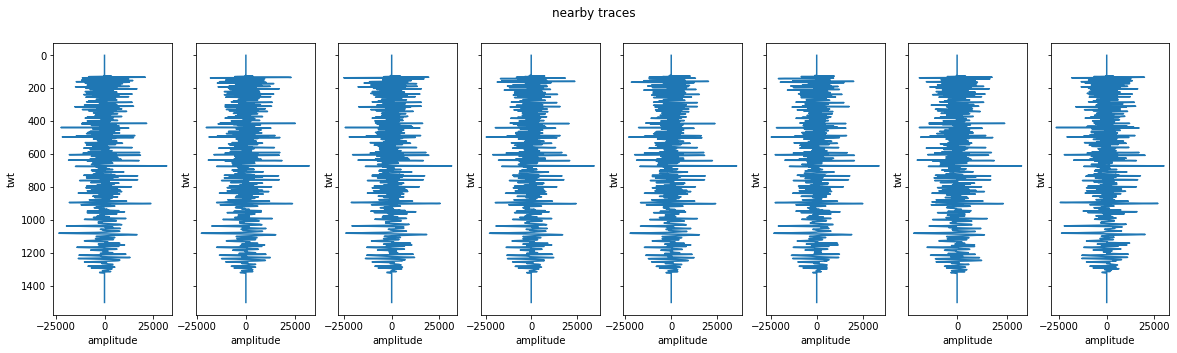

In [39]:
fig, ax = plt.subplots(1, 8, sharey='all',figsize=(20,5))
fig.suptitle('nearby traces')
for idx in range(traces.shape[1]):
    ax[idx].plot(traces[:,idx], np.arange(len(traces[:,idx])))
    ax[idx].set_ylabel('twt')
    ax[idx].set_xlabel('amplitude')

ax[0].invert_yaxis()

## Compute cross-corelation of the extracted traces

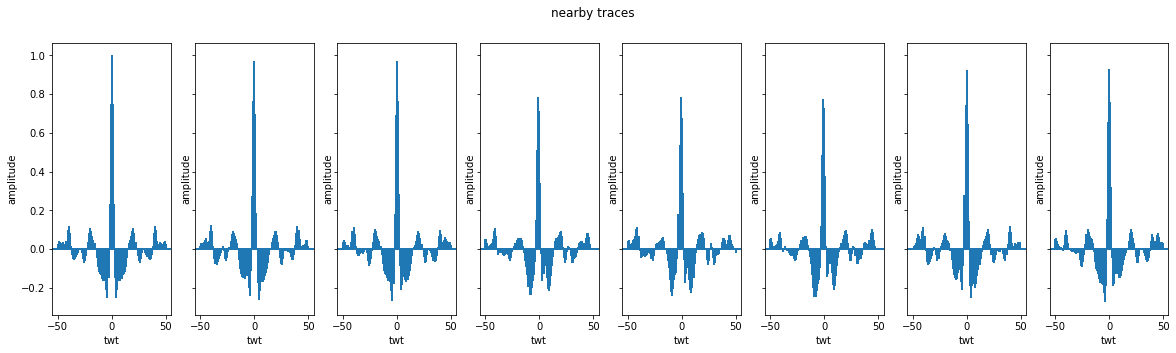

In [40]:
fig, ax = plt.subplots(1, 8, sharey='all',figsize=(20,5))
fig.suptitle('nearby traces')
for idx in range(traces.shape[1]):
    #ax[idx].plot(traces[:,idx], np.arange(len(traces[:,idx])))
    ax[idx].xcorr(traces[:,0], traces[:,idx], usevlines=True, maxlags=50, normed=True, lw=2)
    ax[idx].set_xlabel('twt')
    ax[idx].set_ylabel('amplitude')

#ax[0].invert_yaxis()

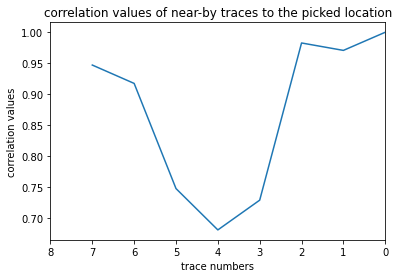

In [41]:
## Check the cross-corelation of the near-by well
def get_xcorr_trace_nearby(traces):
    xcor_trc = []
    for idx in range(traces.shape[1]):
        corr_norm = np.max(np.correlate(traces[:,0], traces[:,0]))
        tmp = np.max(np.correlate(traces[:,0], traces[:,idx])/corr_norm )
        xcor_trc.append(tmp)
        
    return xcor_trc

xcorr_max = get_xcorr_trace_nearby(traces)
plt.figure()
plt.plot(np.arange(len(xcorr_max)), xcorr_max)
plt.xlim([len(xcorr_max),0])
plt.title('correlation values of near-by traces to the picked location')
plt.ylabel('correlation values')
plt.xlabel('trace numbers')
plt.show()
    

In [42]:
rss.trace(1337, 2000)

(array([-0.52195807, -0.52195807, -0.52195807, ..., -0.52195807,
        -0.52195807, -0.52195807]),
 array([False, False, False, ..., False, False, False]))

Let's now try to get a quick estimate of the wavelet in our data using a simple *statistical wavelet* estimation in frequency domain.

Note that this notebook is not focused on the pre-processing but we will need access to this to apply a relative seismic inversion.

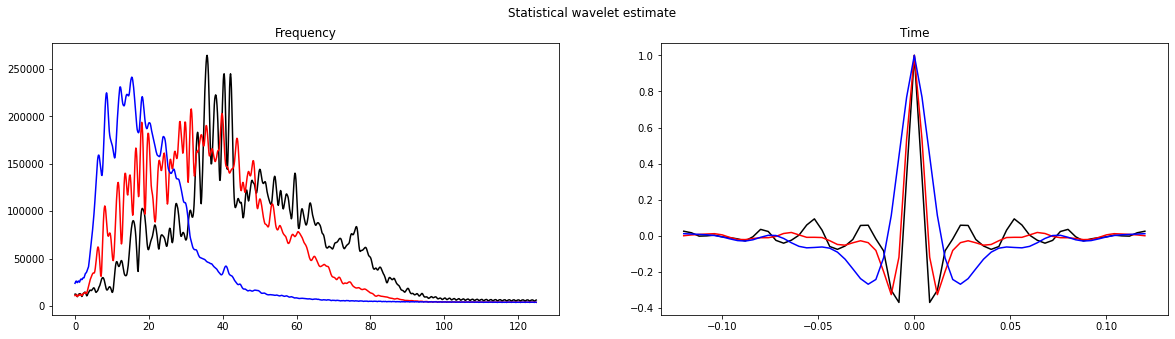

In [43]:
d = inline.T
d = d[:2500]
dt=4 ## might need to changes this
nt_wav = 31 # lenght of wavelet in samples
nfft = 2**11 # lenght of fft

def get_wav_state(d, st, et):
    
    # time axis for wavelet
    t_wav = np.arange(nt_wav) * (dt/1000) 
    t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

    # estimate wavelet spectrum
    wav_est_fft = np.mean(np.abs(np.fft.fft(d[..., st:et], nfft, axis=-1)), axis=0)
    fwest = np.fft.fftfreq(nfft, d=dt/1000)

    # create wavelet in time
    wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
    wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
    wav_est = wav_est / wav_est.max()
    wcenter = np.argmax(np.abs(wav_est))

    return fwest, wav_est_fft, t_wav, wav_est

fwest_sh, wav_est_fft_sh, t_wav_sh, wav_est_sh = get_wav_state(d, 200, 400)
fwest_md, wav_est_fft_md, t_wav_md, wav_est_md = get_wav_state(d, 500, 700)
fwest_dp, wav_est_fft_dp, t_wav_dp, wav_est_dp = get_wav_state(d, 1000, 1200)

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest_sh[:nfft//2], wav_est_fft_sh[:nfft//2], 'k')
axs[0].plot(fwest_md[:nfft//2], wav_est_fft_md[:nfft//2], 'r')
axs[0].plot(fwest_dp[:nfft//2], wav_est_fft_dp[:nfft//2], 'b')
axs[0].set_title('Frequency')
axs[1].plot(t_wav_sh, wav_est_sh, 'k')
axs[1].plot(t_wav_md, wav_est_md, 'r')
axs[1].plot(t_wav_dp, wav_est_dp, 'b')
axs[1].set_title('Time');

In [44]:
## Get wavelet from welllog - 
## Redo wavelet from target formation - 

In [45]:
rss.xy[1337,:]

array([4.03329690e+09, 8.45833723e+10])

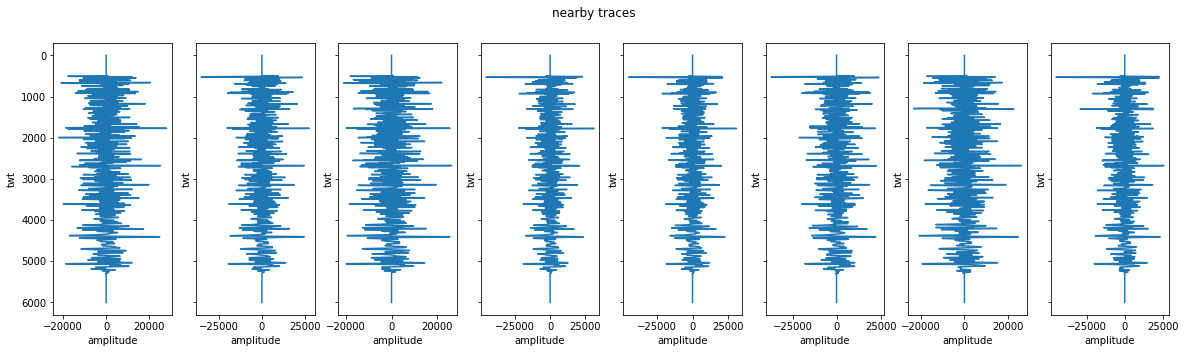

In [46]:
dt = 4
def get_trace_around(rss, num, ntrc):
    dist, ilxl = rss.query_by_xy(rss.xy[num,:], k=ntrc)
    traces = np.vstack([rss.trace(*i)[0] for i in ilxl[0]]).T
    return traces

trace_from_1200 =  get_trace_around(rss, 1200, 25)

fig, ax = plt.subplots(1, 8, sharey='all',figsize=(20,5))
fig.suptitle('nearby traces')
idx = 0
for i in range(1, trace_from_1200.shape[1], 3):
    ax[idx].plot(trace_from_1200[:,i], dt*np.arange(len(trace_from_1200[:,i])))
    ax[idx].set_ylabel('twt')
    ax[idx].set_xlabel('amplitude')
    idx += 1

ax[0].invert_yaxis()

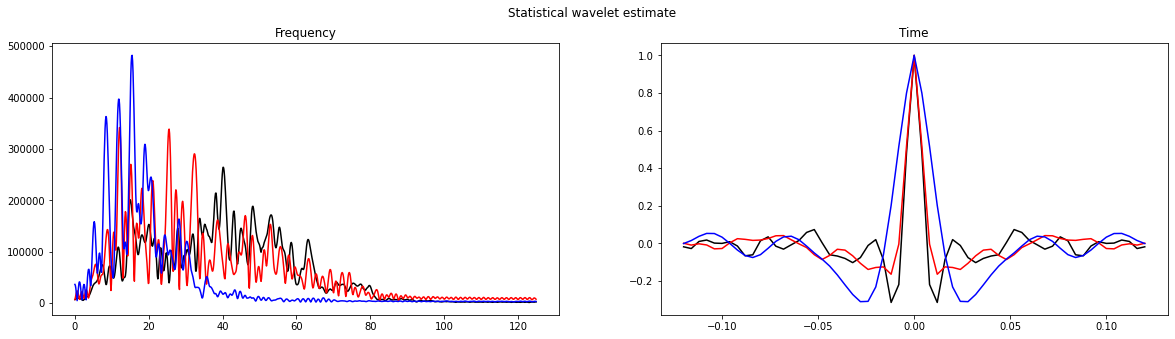

In [47]:
d = trace_from_1200.T
fwest_sh, wav_est_fft_sh, t_wav_sh, wav_est_sh = get_wav_state(d, 200, 400)
fwest_md, wav_est_fft_md, t_wav_md, wav_est_md = get_wav_state(d, 500, 700)
fwest_dp, wav_est_fft_dp, t_wav_dp, wav_est_dp = get_wav_state(d, 1000, 1200)

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest_sh[:nfft//2], wav_est_fft_sh[:nfft//2], 'k')
axs[0].plot(fwest_md[:nfft//2], wav_est_fft_md[:nfft//2], 'r')
axs[0].plot(fwest_dp[:nfft//2], wav_est_fft_dp[:nfft//2], 'b')
axs[0].set_title('Frequency')
axs[1].plot(t_wav_sh, wav_est_sh, 'k')
axs[1].plot(t_wav_md, wav_est_md, 'r')
axs[1].plot(t_wav_dp, wav_est_dp, 'b')
axs[1].set_title('Time');

In [48]:
from scipy import signal
from scipy.fftpack import fft, fftshift
window = signal.tukey(201)

print(d.shape, window.shape)
wind_ext = np.pad(window, (int((d.shape[1]-len(window))/2), ),  'constant', constant_values=0)
d_win = np.zeros(d.shape)
for i in range(d.shape[0]):
    d_win[i, :] = np.multiply(d[i, :],wind_ext) #np.convolve(d[i, :],wind_ext, 'same')

print(d_win.shape)

(25, 1501) (201,)
(25, 1501)


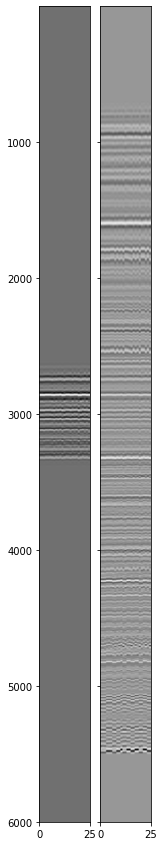

In [49]:
time_seismic = dt*np.arange(0, d.shape[1])
fig, ax = plt.subplots(1, 2, sharey='all',figsize=(2,15))
ax[0].imshow(d_win.T, cmap='gray', aspect='auto', extent=[0, d_win.shape[0], time_seismic[1], time_seismic[-1]])
ax[1].imshow(d.T, cmap='gray', aspect='auto', extent=[0, d_win.shape[0], time_seismic[1], time_seismic[-1]])

ax[0].invert_yaxis()
#ax[1].invert_yaxis()

## Look into the near, mid, far and maybe full

In [50]:
trace_full_1200 =  get_trace_around(rss, 1200, 25)
trace_near_1200 =  get_trace_around(rss_n, 1200, 25)
trace_mid_1200 =  get_trace_around(rss_m, 1200, 25)
trace_far_1200 =  get_trace_around(rss_f, 1200, 25)

Assembling a tree to map il/xl to x/y. 
This could take a couple of minutes, 
But only happens one time.
Assembling a tree to map il/xl to x/y. 
This could take a couple of minutes, 
But only happens one time.
Assembling a tree to map il/xl to x/y. 
This could take a couple of minutes, 
But only happens one time.


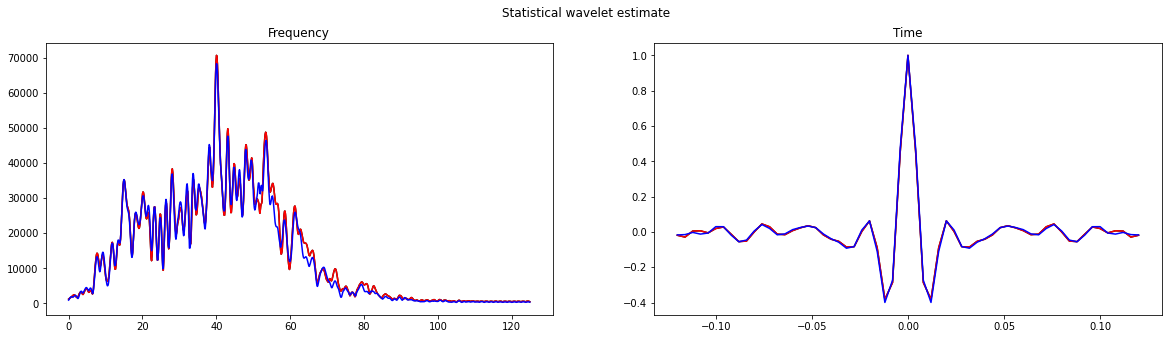

In [51]:
## Shallow - 
d = trace_from_1200.T
fwest_fl, wav_est_fft_fl, t_wav_fl, wav_est_fl = get_wav_state(trace_full_1200.T, 200, 400)
fwest_n, wav_est_fft_n, t_wav_n, wav_est_n = get_wav_state(trace_near_1200.T, 200, 400)
fwest_m, wav_est_fft_m, t_wav_m, wav_est_m = get_wav_state(trace_mid_1200.T, 200, 400)
fwest_f, wav_est_fft_f, t_wav_f, wav_est_f = get_wav_state(trace_far_1200.T, 200, 400)

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest_n[:nfft//2], wav_est_fft_n[:nfft//2], 'k')
axs[0].plot(fwest_m[:nfft//2], wav_est_fft_m[:nfft//2], 'r')
axs[0].plot(fwest_f[:nfft//2], wav_est_fft_f[:nfft//2], 'b')
axs[0].set_title('Frequency')
axs[1].plot(t_wav_n, wav_est_n, 'k')
axs[1].plot(t_wav_m, wav_est_m, 'r')
axs[1].plot(t_wav_f, wav_est_f, 'b')
axs[1].set_title('Time');

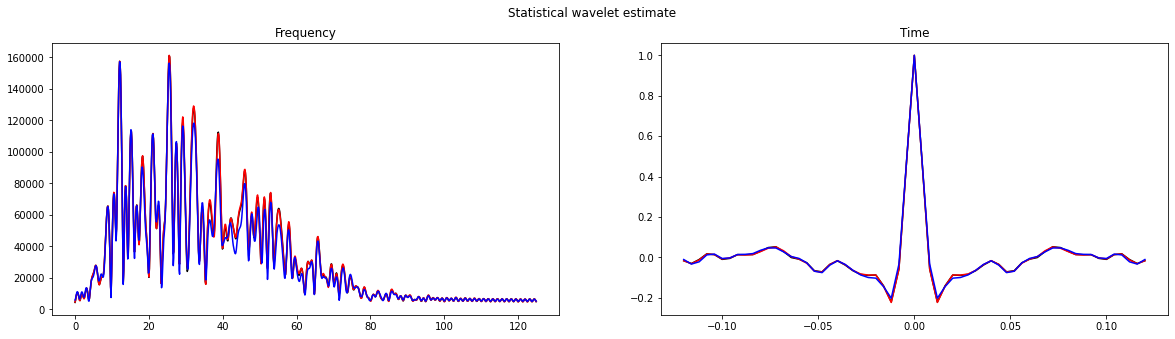

In [52]:
## mid depth - 
d = trace_from_1200.T
fwest_fl, wav_est_fft_fl, t_wav_fl, wav_est_fl = get_wav_state(trace_full_1200.T, 500, 700)
fwest_n, wav_est_fft_n, t_wav_n, wav_est_n = get_wav_state(trace_near_1200.T, 500, 700)
fwest_m, wav_est_fft_m, t_wav_m, wav_est_m = get_wav_state(trace_mid_1200.T, 500, 700)
fwest_f, wav_est_fft_f, t_wav_f, wav_est_f = get_wav_state(trace_far_1200.T, 500, 700)

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest_n[:nfft//2], wav_est_fft_n[:nfft//2], 'k')
axs[0].plot(fwest_m[:nfft//2], wav_est_fft_m[:nfft//2], 'r')
axs[0].plot(fwest_f[:nfft//2], wav_est_fft_f[:nfft//2], 'b')
axs[0].set_title('Frequency')
axs[1].plot(t_wav_n, wav_est_n, 'k')
axs[1].plot(t_wav_m, wav_est_m, 'r')
axs[1].plot(t_wav_f, wav_est_f, 'b')
axs[1].set_title('Time');

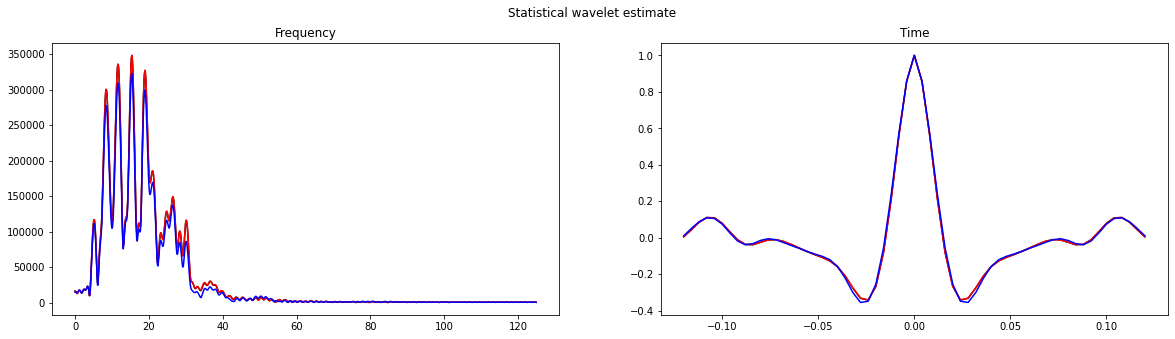

In [53]:
## deep depth - 
d = trace_from_1200.T
fwest_fl, wav_est_fft_fl, t_wav_fl, wav_est_fl = get_wav_state(trace_full_1200.T, 1000, 1200)
fwest_n, wav_est_fft_n, t_wav_n, wav_est_n = get_wav_state(trace_near_1200.T, 1000, 1200)
fwest_m, wav_est_fft_m, t_wav_m, wav_est_m = get_wav_state(trace_mid_1200.T, 1000, 1200)
fwest_f, wav_est_fft_f, t_wav_f, wav_est_f = get_wav_state(trace_far_1200.T, 1000, 1200)

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest_n[:nfft//2], wav_est_fft_n[:nfft//2], 'k')
axs[0].plot(fwest_m[:nfft//2], wav_est_fft_m[:nfft//2], 'r')
axs[0].plot(fwest_f[:nfft//2], wav_est_fft_f[:nfft//2], 'b')
axs[0].set_title('Frequency')
axs[1].plot(t_wav_n, wav_est_n, 'k')
axs[1].plot(t_wav_m, wav_est_m, 'r')
axs[1].plot(t_wav_f, wav_est_f, 'b')
axs[1].set_title('Time');

0.24 481 61


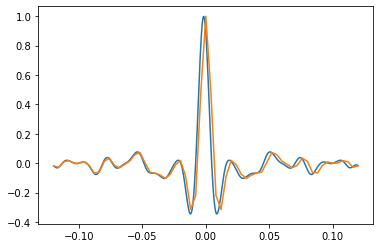

2048


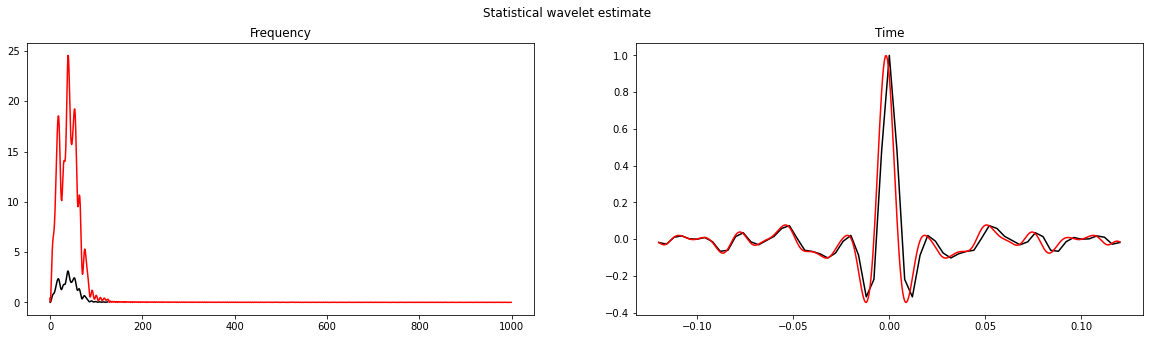

In [54]:
from sklearn.utils import resample

def prep_wavelet_4_log(t_wav, wav_est):
    time=t_wav
    dt_log = 0.0005
    time_log = np.linspace(time[0], time[-1], int((time[-1]-time[0])/dt_log) + 1)
    print(time[-1]-time[0], len(time_log), len(time))
    wav_est_log = signal.resample(wav_est, len(time_log))
    #wav_est_log = signal.resample_poly(wav_est, len(time_log)*10, int(len(time_log)/10))
    
    #wav_est_log = resample(wav_est, n_samples=len(time_log))
    
    
    wav_est_fft = np.abs(np.fft.fft(wav_est, nfft, axis=-1)) #, axis=0)
    wav_est_log_fft = np.abs(np.fft.fft(wav_est_log, nfft, axis=-1)) #, axis=0)
    fwest_log = np.fft.fftfreq(nfft, d=dt_log)
    fwest = np.fft.fftfreq(nfft, d=4/1000)
    
    return time_log, wav_est_log, wav_est_fft, wav_est_log_fft, fwest,fwest_log 

time_sh_log, wav_est_sh_log, wav_est_fft, wav_est_log_fft, fwest,fwest_log = prep_wavelet_4_log(t_wav_sh, wav_est_sh)

plt.figure()
plt.plot(time_sh_log, wav_est_sh_log)
plt.plot(t_wav_sh, wav_est_sh)
#plt.xlim([len(xcorr_max),0])
plt.show()

print(len(fwest))

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].plot(fwest_log[:nfft//2], wav_est_log_fft[:nfft//2], 'r')
#axs[0].plot(fwest_dp[:nfft//2], wav_est_fft_dp[:nfft//2], 'b')
axs[0].set_title('Frequency')
axs[1].plot(t_wav_sh, wav_est_sh, 'k')
axs[1].plot(time_sh_log, wav_est_sh_log, 'r')
#axs[1].plot(t_wav_dp, wav_est_dp, 'b')
axs[1].set_title('Time');

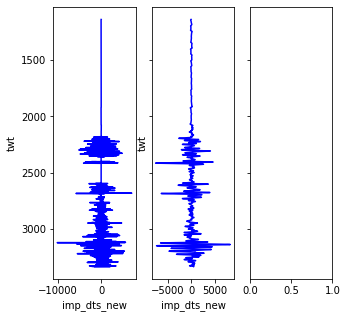

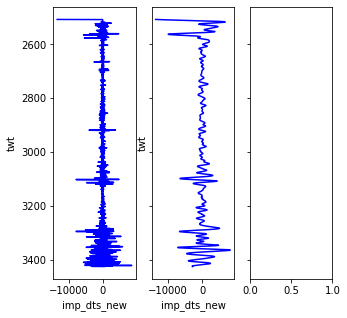

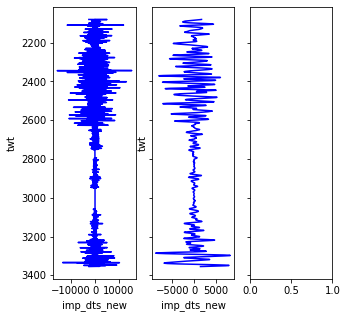

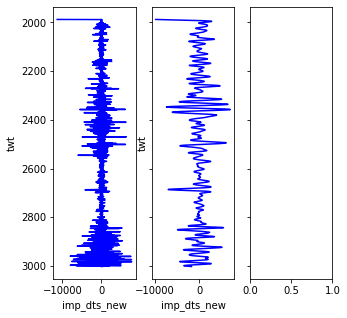

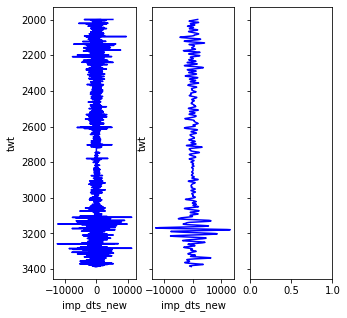

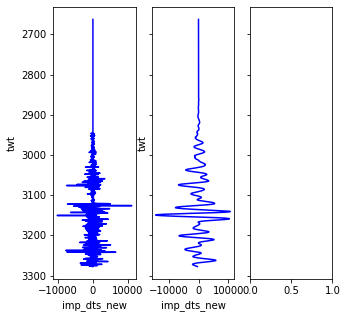

In [55]:
###  get well synthetic

#Need to get the well locations

for well in well_data.index.levels[0]:
    fig, ax = plt.subplots(1, 3, sharey='all',figsize=(5,5))
    curves = well_data.loc[well][['imp_dtc_new', 'imp_dts_new']]
    curves = curves.fillna(0)
    time=curves['imp_dts_new'].index
    well_syn = np.convolve(wav_est_sh_log, curves['imp_dts_new'], mode='same')
    ax[0].plot(curves['imp_dts_new'], curves['imp_dts_new'].index, 'b')
    ax[0].set_ylabel(curves['imp_dts_new'].index.name)
    ax[0].set_xlabel(curves['imp_dts_new'].name)
    
    ax[1].plot(well_syn, curves['imp_dts_new'].index, 'b')
    ax[1].set_ylabel(curves['imp_dts_new'].index.name)
    ax[1].set_xlabel(curves['imp_dts_new'].name)
    
    
    ax[0].invert_yaxis()

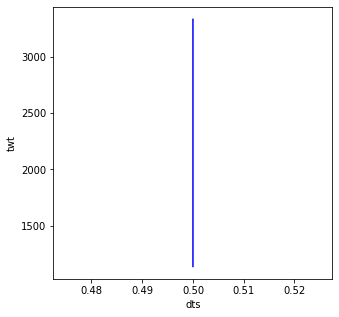

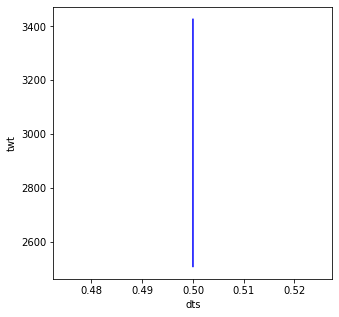

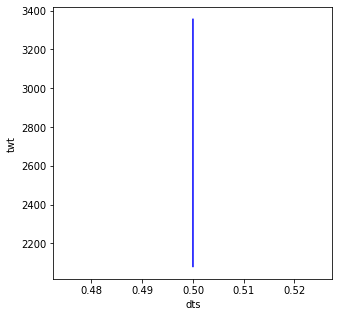

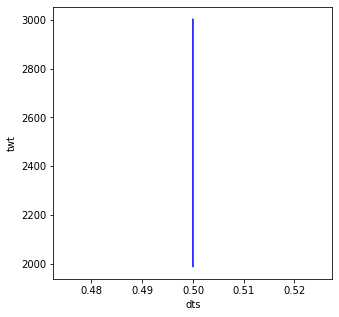

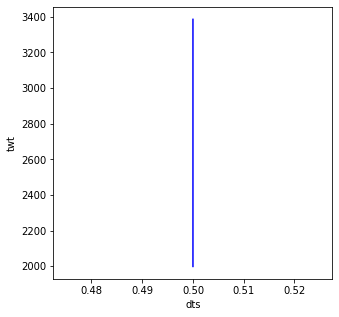

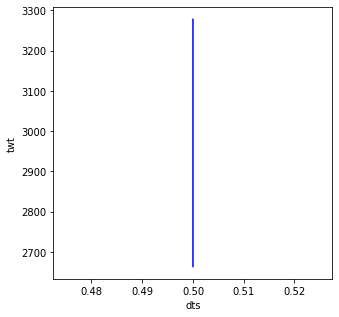

In [56]:
### Get the well synthetic QC time interval
#well_data

for well in well_data.index.levels[0]:
    fig, ax = plt.subplots(1, 1, sharey='all',figsize=(5,5))
    curves = well_data.loc[well][['dts']]
    curves = curves.fillna(0)
    time=curves['dts'].index
    dt_cuv = np.diff(time, prepend=np.nan)
    
    ax.plot(dt_cuv, curves['dts'].index, 'b')
    ax.set_ylabel(curves['dts'].index.name)
    ax.set_xlabel(curves['dts'].name)

In [57]:
rss.query_by_xy

<bound method rssClient.query_by_xy of <rss.client.rssFromS3 object at 0x7fb6530a8490>>

In [58]:
ilxl = rss.ilxl
print(ilxl.shape, np.min(ilxl[:, 0]),  np.max(ilxl[:, 0]),  np.min(ilxl[:, 1]), np.max(ilxl[:, 1]))
il_range = np.max(ilxl[:, 0]) -  np.min(ilxl[:, 0]) + 1
xl_range = np.max(ilxl[:, 1]) -  np.min(ilxl[:, 1]) + 1
ntime = 1501
def get_3Ddata(rss, ilxl, il_range, xl_range):
    
    data_3D = np.zeros((ntime, il_range, xl_range))
    for xl in range(np.min(ilxl[0, :]), np.max(ilxl[:, 0])):
        #ixline, mask = rss.line(xl, sort_order='crossline')
        #data_3D[:, :, xl] = ixline
    return data_3D

data_d = get_3Ddata(rss, ilxl, il_range, xl_range)
        

IndentationError: expected an indented block (<ipython-input-58-51a66a7088d9>, line 12)